## Training neural network by hand/numpy
* Go over a neural network training process without using Pytorch or tensor flow
* 100% numpy with backward propgation, optimization implemented. 

## Preload the data 
We will using the image MNIST datast:
* MNIST database is widely used for training and testing in neural network, as no feature engineering is needed
* Dataset with multiple images as a handwriten number collected from the letter in USPS where people used to handwritten the postal code
* Each image is pixel by pixel, can be reshaped as a 2-D array 28*28 represent each image
* 0 in pixel represent black, and other numbers 1-9 represent different level of gray white color
* The testing data set (10,000 rows, 785 columns, 784 can be reshaped as 28*28, 1st value is label of number 0-9)

In [33]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
import random
import copy

In [34]:
# ### read data as an example
# with open('data/mnist_test.csv', 'r') as csv_file:
#     csvreader = csv.reader(csv_file)
#     next(csvreader)
#     for data in csvreader:
        
#         # The first column is the label
#         label = data[0]

#         # The rest of columns are pixels
#         pixels = data[1:]

#         # Make those columns into a array of 8-bits pixels
#         # This array will be of 1D with length 784
#         # The pixel intensity values are integers from 0 to 255
#         pixels = np.array(pixels, dtype = 'int64')
#         print(pixels.shape)
#         # Reshape the array into 28 x 28 array (2-dimensional array)
#         pixels = pixels.reshape((28, 28))
#         print(pixels.shape)
#         # Plot
#         plt.title('Label is {label}'.format(label=label))
#         plt.imshow(pixels, cmap='gray')
#         plt.show()

## 0. Data Loading and Preprocessing 
Let's implement data loading utilities (we'll simulate MNIST data for this demo):


Loading MNIST dataset from CSV files...
Expected file structure:
  data/
    ├── mnist_train.csv
    └── mnist_test.csv

Loading training data...
Training data loaded with 60000 images
Split into 48000 training and 12000 validation samples
Loading testing data...
Testing data loaded with 10000 images

Dataset loaded successfully!
Training data: 48000 samples
Validation data: 12000 samples
Test data: 10000 samples
Input dimension: 784 (28x28 flattened)
Number of classes: 10

Class distribution in training data:
  Class 0: 4729 samples (9.9%)
  Class 1: 5470 samples (11.4%)
  Class 2: 4762 samples (9.9%)
  Class 3: 4889 samples (10.2%)
  Class 4: 4655 samples (9.7%)
  Class 5: 4324 samples (9.0%)
  Class 6: 4748 samples (9.9%)
  Class 7: 4968 samples (10.3%)
  Class 8: 4653 samples (9.7%)
  Class 9: 4802 samples (10.0%)

Visualizing sample images...


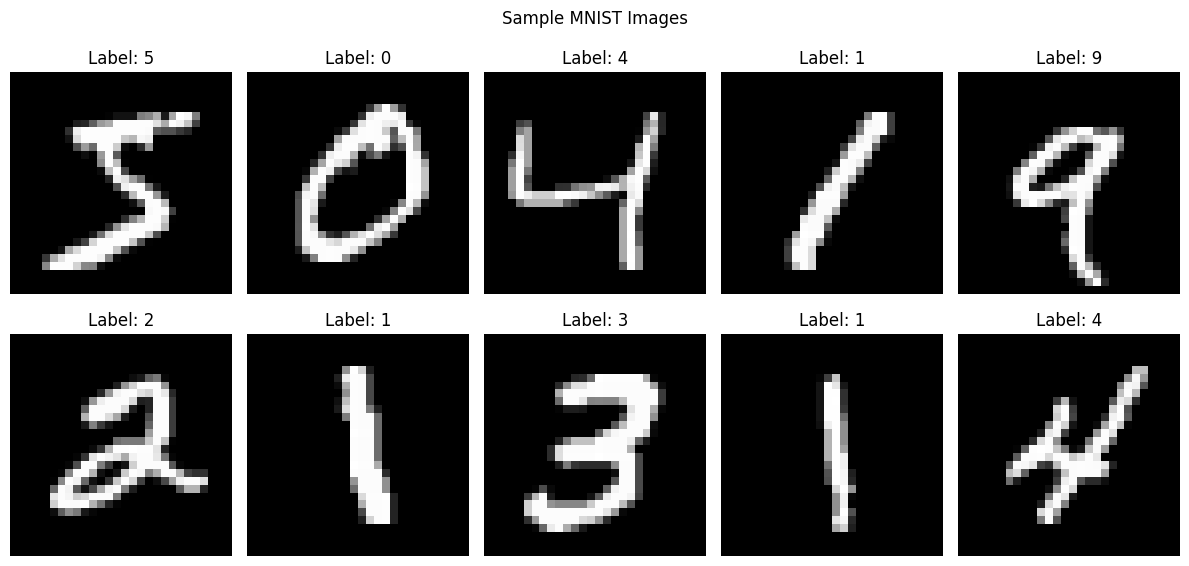

In [35]:
def load_csv(path):
    """
    Load the CSV form of MNIST data without any external library
    :param path: the path of the csv file
    :return:
        data: A list of list where each sub-list with 28x28 elements
              corresponding to the pixels in each image
        labels: A list containing labels of images
    """
    data = []
    labels = []
    with open(path, 'r') as fp:
        images = fp.readlines()
        images = [img.rstrip() for img in images]

        for img in images:
            img_as_list = img.split(',')
            y = int(img_as_list[0])  # first entry as label
            x = img_as_list[1:]
            x = [int(px) / 255 for px in x]  # normalize to [0,1]
            data.append(x)
            labels.append(y)
    return data, labels

def load_mnist_trainval():
    """
    Load MNIST training data with labels and split into train/validation
    :return:
        train_data: A list of list containing the training data
        train_label: A list containing the labels of training data
        val_data: A list of list containing the validation data
        val_label: A list containing the labels of validation data
    """
    # Load training data
    print("Loading training data...")
    data, label = load_csv('./data/mnist_train.csv')
    assert len(data) == len(label)
    print("Training data loaded with {count} images".format(count=len(data)))

    # Split training/validation data (80% train, 20% validation)
    train_pct = int(0.8 * len(data))
    train_data = data[:train_pct]
    val_data = data[train_pct:]
    train_label = label[:train_pct]
    val_label = label[train_pct:]
    
    print(f"Split into {len(train_data)} training and {len(val_data)} validation samples")
    
    return train_data, train_label, val_data, val_label

def load_mnist_test():
    """
    Load MNIST testing data with labels
    :return:
        data: A list of list containing the testing data
        label: A list containing the labels of testing data
    """
    print("Loading testing data...")
    data, label = load_csv('./data/mnist_test.csv')
    assert len(data) == len(label)
    print("Testing data loaded with {count} images".format(count=len(data)))
    return data, label

def generate_batched_data(data, label, batch_size=32, shuffle=False, seed=None):
    """
    Turn raw data into batched forms
    :param data: A list of list containing the data where each inner list contains 28x28
                 elements corresponding to pixel values in images
    :param label: A list containing the labels of data
    :param batch_size: required batch size
    :param shuffle: Whether to shuffle the data: true for training and False for testing
    :return:
        batched_data: (List[np.ndarray]) A list whose elements are batches of images.
        batched_label: (List[np.ndarray]) A list whose elements are batches of labels.
    """
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    
    # Combine data and labels for shuffling
    zip_data = zip(data, label)
    zip_list = list(zip_data)
    
    if shuffle:
        random.shuffle(zip_list)
        shuffle_data, shuffle_label = zip(*zip_list)
        shuffle_data = list(shuffle_data)
        shuffle_label = list(shuffle_label)
    else:
        # If shuffle is False, use the original data and labels
        shuffle_data = data
        shuffle_label = label
    
    # Create batches
    batched_data = []
    batched_label = []
    for i in range(0, len(data), batch_size):
        batched_data.append(np.array(shuffle_data[i:i+batch_size]))
        batched_label.append(np.array(shuffle_label[i:i+batch_size]))
    
    return batched_data, batched_label

def visualize_mnist_samples(data, labels, num_samples=10):
    """Visualize some MNIST samples"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Reshape flattened image back to 28x28
        image = np.array(data[i]).reshape(28, 28)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')
    
    plt.suptitle('Sample MNIST Images')
    plt.tight_layout()
    plt.show()

# Load actual MNIST data
print("Loading MNIST dataset from CSV files...")
print("Expected file structure:")
print("  data/")
print("    ├── mnist_train.csv")
print("    └── mnist_test.csv")
print()

try:
    # Load training and validation data
    train_data, train_labels, val_data, val_labels = load_mnist_trainval()
    
    # Load test data
    test_data, test_labels = load_mnist_test()
    
    print(f"\nDataset loaded successfully!")
    print(f"Training data: {len(train_data)} samples")
    print(f"Validation data: {len(val_data)} samples") 
    print(f"Test data: {len(test_data)} samples")
    print(f"Input dimension: {len(train_data[0])} (28x28 flattened)")
    print(f"Number of classes: {len(set(train_labels))}")
    
    # Show class distribution
    unique_labels, counts = np.unique(train_labels, return_counts=True)
    print(f"\nClass distribution in training data:")
    for label, count in zip(unique_labels, counts):
        print(f"  Class {label}: {count} samples ({count/len(train_labels)*100:.1f}%)")
    
    # Visualize some samples
    print("\nVisualizing sample images...")
    visualize_mnist_samples(train_data, train_labels, num_samples=10)
    
except FileNotFoundError as e:
    print(f"Error: Could not find MNIST CSV files in ./data/ directory")
    print(f"Please ensure you have:")
    print(f"  - ./data/mnist_train.csv")
    print(f"  - ./data/mnist_test.csv")
    print(f"\nYou can download MNIST CSV files from:")
    print(f"  https://www.kaggle.com/datasets/oddrationale/mnist-in-csv")
    raise e

### Making same analogy 
* Imagine we are build a credit underwriting rating model
* we have **10**  ratings from AAA to D ratings
* we have a training dataset, with 48000 companies, each company had **28** "features" (balance, EPS, NOI, expense, tax, EBIT etc...)
* each company have **28** month history, like CCAR 9 quarter
* we wants to build a nn model, similar to image processing to evaluate the crediting rating
* Everything else are the same as MNIST image dataset!

## 0.5 Relationship between Neural network and Logistical Regression

### Connection between logistical and neural network
https://sebastianraschka.com/faq/docs/logisticregr-neuralnet.html

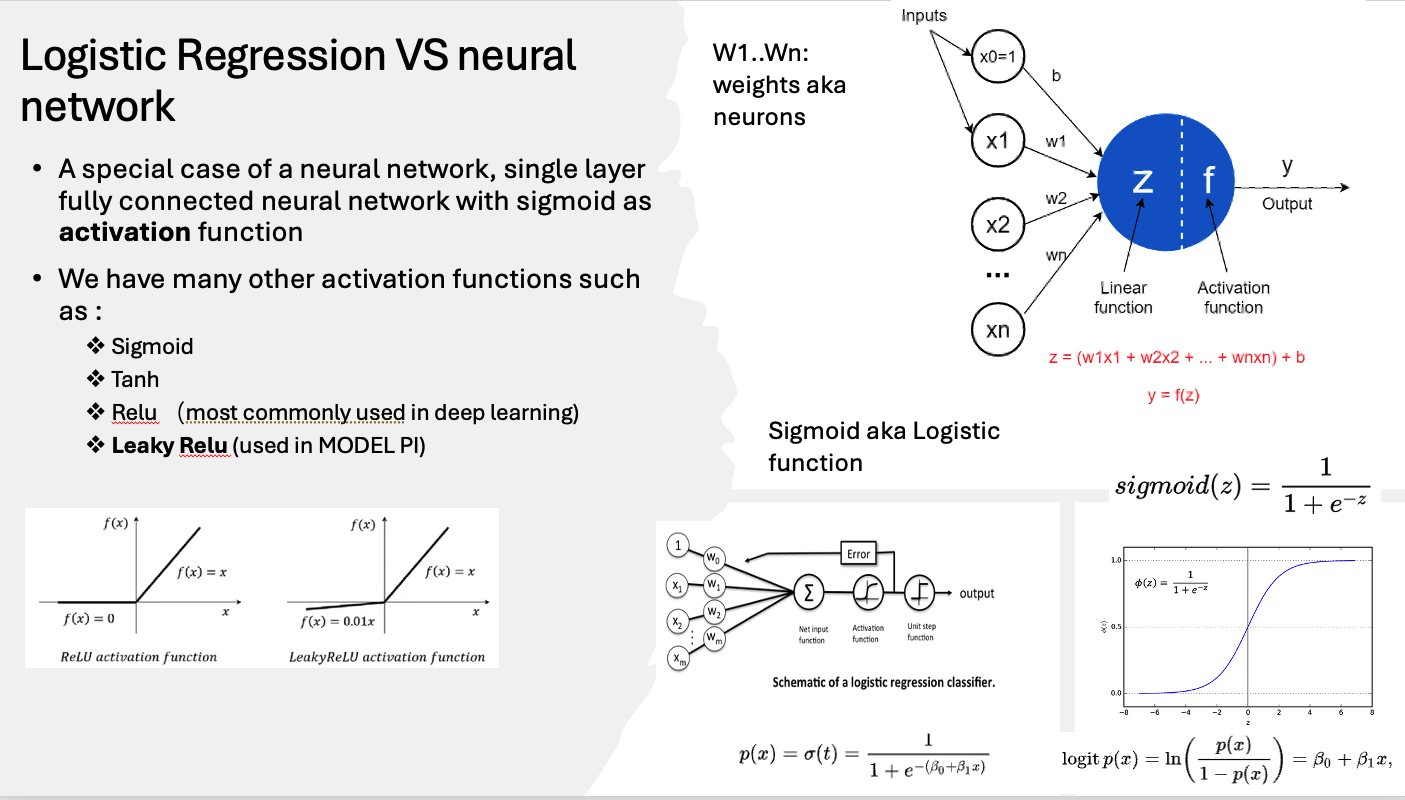

# Neural Network End-to-End Training Process
*A Complete Implementation from Scratch*

This notebook demonstrates the complete neural network training process using custom implementations of:
- Base neural network architecture
- Softmax regression
- Two-layer neural network
- SGD optimizer
- Training and evaluation utilities

## Table of Contents
0. Data Loading and Preprocessing
1. Introduction
2. Base Network Architecture
3. Activation Functions and Loss Functions
4. Softmax Regression Model
5. Two-Layer Neural Network
6. Optimizer Implementation
7. Training Pipeline
8. Complete Training Example
9. Results and Visualization

---



---

## 1. Introduction

This notebook implements neural networks from scratch using only NumPy. We'll build:
- A **Softmax Regression** model (single layer)
- A **Two-Layer Neural Network** with sigmoid activation
- Complete training pipeline with SGD optimization

### Key Concepts Covered:
- Forward propagation
- Backpropagation and gradient computation
- Loss functions (Cross-entropy)
- Activation functions (Sigmoid, ReLU, Softmax)
- L2 regularization
- Batch processing

---

## 2. Base Network infrastructure

First, let's implement the base network class that provides common functionality:



In [36]:


class _baseNetwork:
    def __init__(self, input_size=28 * 28, num_classes=10):
        self.input_size = input_size
        self.num_classes = num_classes
        self.weights = dict()
        self.gradients = dict()

    def _weight_init(self):
        pass

    def forward(self):
        pass

    def softmax(self, scores):
        """
        Compute softmax scores given the raw output from the model
        :param scores: raw scores from the model (N, num_classes)
        :return: prob: softmax probabilities (N, num_classes)
        """
        # Numerical stability: subtract max
        scores_stable = scores - np.max(scores, axis=1, keepdims=True)
        prob = np.exp(scores_stable) / np.sum(np.exp(scores_stable), axis=1, keepdims=True)
        return prob

    def cross_entropy_loss(self, x_pred, y):
        """
        Compute Cross-Entropy Loss based on prediction and labels
        :param x_pred: Probabilities from the model (N, num_classes)
        :param y: Labels of instances in the batch
        :return: The computed Cross-Entropy Loss
        """
        # Vectorized implementation
        selected_probs = x_pred[np.arange(len(y)), y]
        # Add small epsilon for numerical stability
        log_likelihood = -np.log(selected_probs + 1e-15)
        loss = np.mean(log_likelihood)
        return loss

    def compute_accuracy(self, x_pred, y):
        """
        Compute the accuracy of current batch
        :param x_pred: Probabilities from the model (N, num_classes)
        :param y: Labels of instances in the batch
        :return: The accuracy of the batch
        """
        predictions = np.argmax(x_pred, axis=1)
        correct = (predictions == y)
        accuracy = np.mean(correct)
        return accuracy

    def sigmoid(self, X):
        """
        Sigmoid activation function
        Formula: σ(x) = 1 / (1 + e^(-x))
        Derivative: σ'(x) = σ(x)(1 - σ(x))
        """
        # Clip X to prevent overflow
        X_clipped = np.clip(X, -500, 500)
        return 1 / (1 + np.exp(-X_clipped))

    def sigmoid_dev(self, x):
        """
        Derivative of sigmoid function
        σ'(x) = σ(x)(1 - σ(x))
        """
        sig_x = self.sigmoid(x)
        return sig_x * (1 - sig_x)

    def ReLU(self, X):
        """
        ReLU activation function
        Formula: ReLU(x) = max(0, x)
        Derivative: ReLU'(x) = 1 if x > 0, else 0
        """
        return np.maximum(0, X)

    def ReLU_dev(self, X):
        """
        Derivative of ReLU function
        ReLU'(x) = 1 if x > 0, else 0
        """
        return (X > 0).astype(np.float32)
    
    def leaky_relu(self, X, alpha=0.01):
        """
        Leaky ReLU activation function
        Formula: LeakyReLU(x) = x if x > 0, else α*x
        Derivative: LeakyReLU'(x) = 1 if x > 0, else α
        """
        return np.where(X > 0, X, alpha * X)
    
    def leaky_relu_dev(self, X, alpha=0.01):
        """
        Derivative of Leaky ReLU function
        LeakyReLU'(x) = 1 if x > 0, else α
        """
        return np.where(X > 0, 1.0, alpha)
    
    def elu(self, X, alpha=1.0):
        """
        ELU (Exponential Linear Unit) activation function
        Formula: ELU(x) = x if x > 0, else α(e^x - 1)
        Derivative: ELU'(x) = 1 if x > 0, else α*e^x
        """
        return np.where(X > 0, X, alpha * (np.exp(np.clip(X, -500, 500)) - 1))
    
    def elu_dev(self, X, alpha=1.0):
        """
        Derivative of ELU function
        ELU'(x) = 1 if x > 0, else α*e^x
        """
        return np.where(X > 0, 1.0, alpha * np.exp(np.clip(X, -500, 500)))
    
    def tanh(self, X):
        """
        Hyperbolic tangent activation function
        Formula: tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))
        Derivative: tanh'(x) = 1 - tanh^2(x)
        """
        return np.tanh(X)
    
    def tanh_dev(self, X):
        """
        Derivative of tanh function
        tanh'(x) = 1 - tanh^2(x)
        """
        tanh_x = np.tanh(X)
        return 1 - tanh_x**2

## 3. Key functions 
### 3.0 Activation Functions

Let's visualize the activation functions we implemented:

### Mathematical Formulas and Derivatives

#### 1. Sigmoid Function
- **Formula**: $\sigma(x) = \frac{1}{1 + e^{-x}}$
- **Derivative**: $\sigma'(x) = \sigma(x)(1 - \sigma(x))$
- **Range**: $(0, 1)$
- **Properties**: Smooth, differentiable, but suffers from vanishing gradient problem

#### 2. ReLU (Rectified Linear Unit)
- **Formula**: $\text{ReLU}(x) = \max(0, x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}$
- **Derivative**: $\text{ReLU}'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}$
- **Range**: $[0, +\infty)$
- **Properties**: Computationally efficient, but can cause "dying ReLU" problem

#### 3. Leaky ReLU
- **Formula**: $\text{LeakyReLU}(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha x & \text{if } x \leq 0 \end{cases}$ (where $\alpha$ is a small positive constant, typically 0.01)
- **Derivative**: $\text{LeakyReLU}'(x) = \begin{cases} 1 & \text{if } x > 0 \\ \alpha & \text{if } x \leq 0 \end{cases}$
- **Range**: $(-\infty, +\infty)$
- **Properties**: Addresses dying ReLU problem by allowing small negative values

#### 4. ELU (Exponential Linear Unit)
- **Formula**: $\text{ELU}(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha(e^x - 1) & \text{if } x \leq 0 \end{cases}$
- **Derivative**: $\text{ELU}'(x) = \begin{cases} 1 & \text{if } x > 0 \\ \alpha e^x & \text{if } x \leq 0 \end{cases}$
- **Range**: $(-\alpha, +\infty)$
- **Properties**: Smooth everywhere, reduces bias shift

#### 5. Tanh (Hyperbolic Tangent)
- **Formula**: $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}$
- **Derivative**: $\tanh'(x) = 1 - \tanh^2(x)$
- **Range**: $(-1, 1)$
- **Properties**: Zero-centered output, but still suffers from vanishing gradient

#### 6. Softmax (for multi-class classification)
- **Formula**: $\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{K} e^{x_j}}$ for $i = 1, ..., K$
- **Derivative**: $\frac{\partial \text{softmax}(x_i)}{\partial x_j} = \begin{cases} \text{softmax}(x_i)(1 - \text{softmax}(x_i)) & \text{if } i = j \\ -\text{softmax}(x_i)\text{softmax}(x_j) & \text{if } i \neq j \end{cases}$
- **Range**: $(0, 1)$ with $\sum_{i=1}^{K} \text{softmax}(x_i) = 1$
- **Properties**: Converts logits to probability distribution

<>:127: SyntaxWarning: invalid escape sequence '\ '
<>:127: SyntaxWarning: invalid escape sequence '\ '
/var/folders/r6/mlv0p57x04bgh5v0cyfpscv80000gn/T/ipykernel_31794/902138881.py:127: SyntaxWarning: invalid escape sequence '\ '
  print("\ KEY INSIGHTS:")


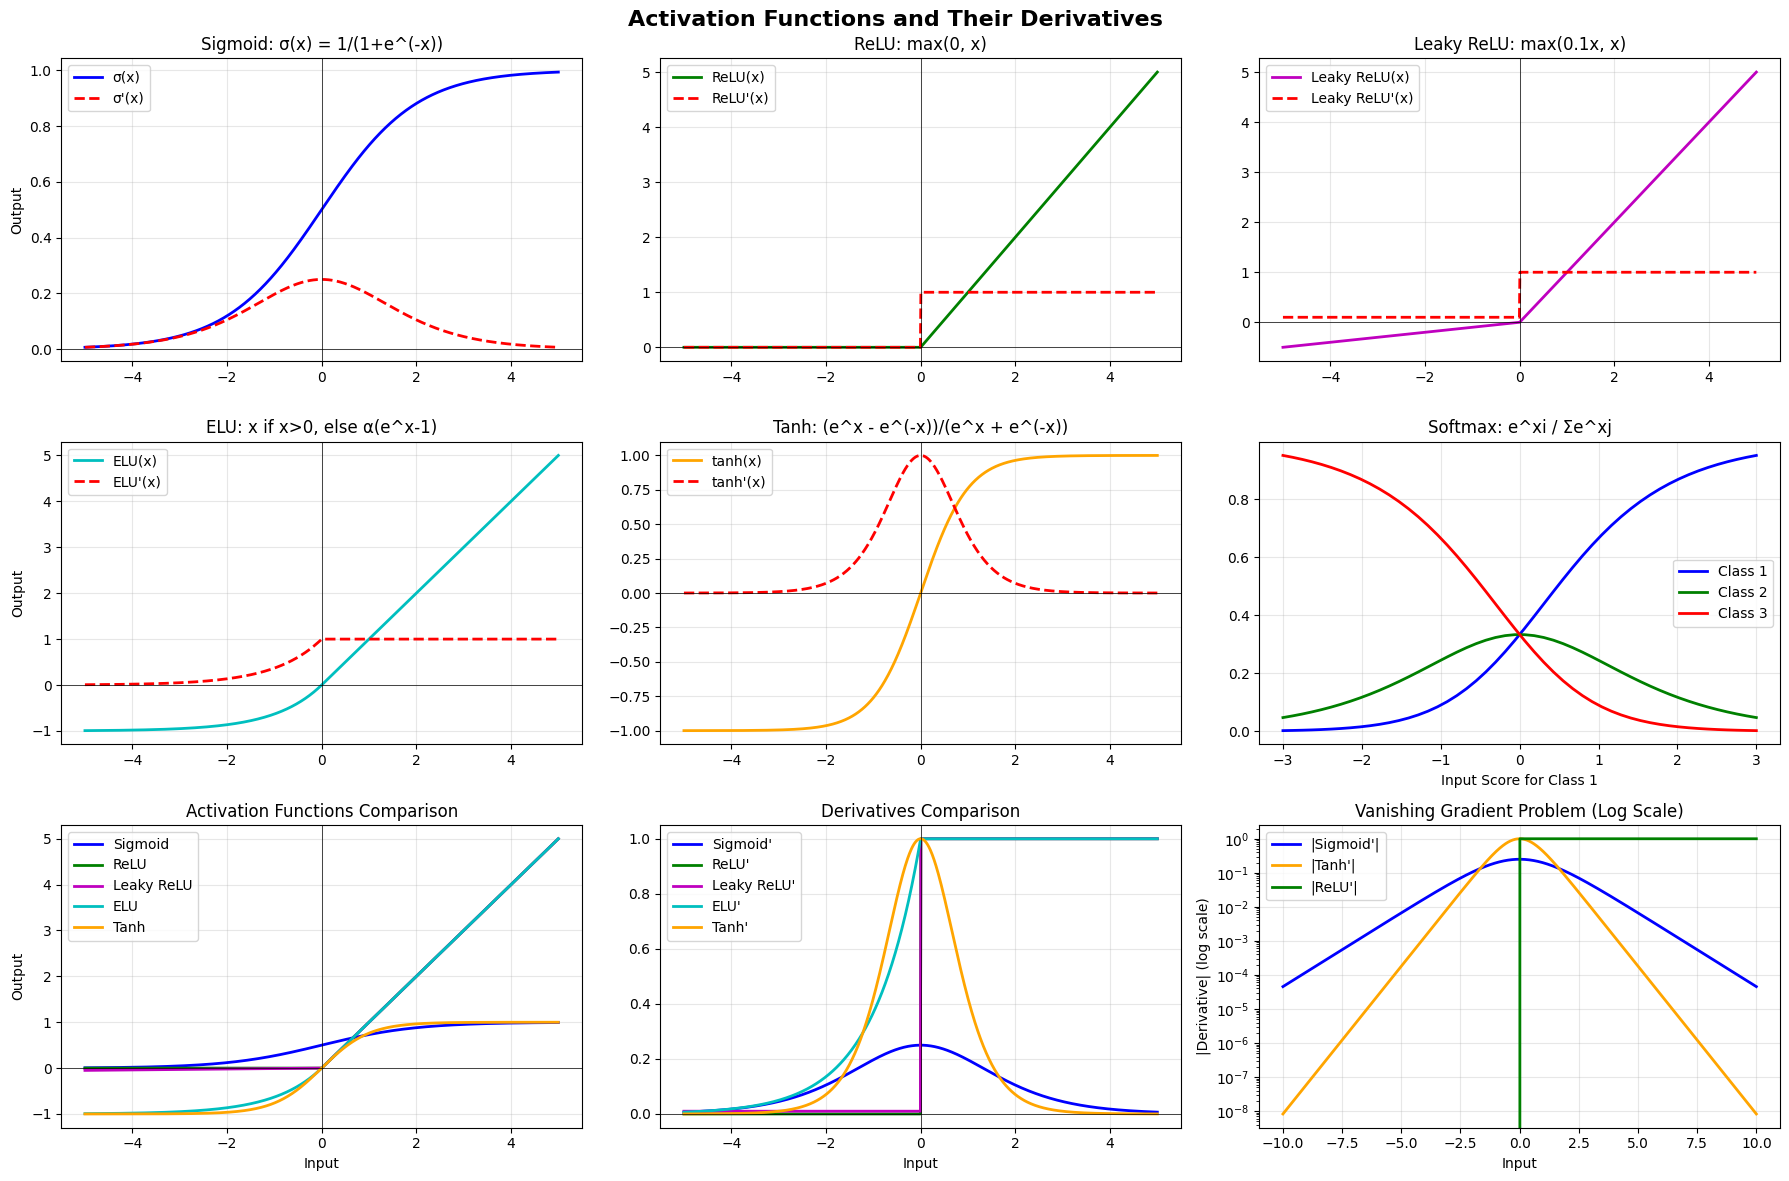

ACTIVATION FUNCTION PROPERTIES
Function        Range                Derivative Max  Zero-Centered  
--------------------------------------------------------------------------------
Sigmoid         (0, 1)               0.25            No             
ReLU            [0, +∞)              1               No             
Leaky ReLU      (-∞, +∞)             1               No             
ELU             (-α, +∞)             1               No             
Tanh            (-1, 1)              1               Yes            
Softmax         (0, 1)               Variable        No             
\ KEY INSIGHTS:
• Sigmoid and Tanh suffer from vanishing gradients for large |x|
• ReLU can cause 'dying neurons' when x ≤ 0
• Leaky ReLU and ELU address the dying neuron problem
• Tanh is zero-centered, which can help with training
• Softmax is used for multi-class classification output layers


In [37]:
# Comprehensive visualization of activation functions and their derivatives
x = np.linspace(-5, 5, 1000)
base_net = _baseNetwork()

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Activation Functions and Their Derivatives', fontsize=16, fontweight='bold')

# Sigmoid
axes[0,0].plot(x, base_net.sigmoid(x), 'b-', linewidth=2, label='σ(x)')
axes[0,0].plot(x, base_net.sigmoid_dev(x), 'r--', linewidth=2, label="σ'(x)")
axes[0,0].set_title('Sigmoid: σ(x) = 1/(1+e^(-x))')
axes[0,0].set_ylabel('Output')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0, color='k', linewidth=0.5)
axes[0,0].axvline(x=0, color='k', linewidth=0.5)

# ReLU
axes[0,1].plot(x, base_net.ReLU(x), 'g-', linewidth=2, label='ReLU(x)')
axes[0,1].plot(x, base_net.ReLU_dev(x), 'r--', linewidth=2, label="ReLU'(x)")
axes[0,1].set_title('ReLU: max(0, x)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='k', linewidth=0.5)
axes[0,1].axvline(x=0, color='k', linewidth=0.5)

# Leaky ReLU
axes[0,2].plot(x, base_net.leaky_relu(x,0.1), 'm-', linewidth=2, label='Leaky ReLU(x)')
axes[0,2].plot(x, base_net.leaky_relu_dev(x,0.1), 'r--', linewidth=2, label="Leaky ReLU'(x)")
axes[0,2].set_title('Leaky ReLU: max(0.1x, x)')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)
axes[0,2].axhline(y=0, color='k', linewidth=0.5)
axes[0,2].axvline(x=0, color='k', linewidth=0.5)

# ELU
axes[1,0].plot(x, base_net.elu(x), 'c-', linewidth=2, label='ELU(x)')
axes[1,0].plot(x, base_net.elu_dev(x), 'r--', linewidth=2, label="ELU'(x)")
axes[1,0].set_title('ELU: x if x>0, else α(e^x-1)')
axes[1,0].set_ylabel('Output')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='k', linewidth=0.5)
axes[1,0].axvline(x=0, color='k', linewidth=0.5)

# Tanh
axes[1,1].plot(x, base_net.tanh(x), 'orange', linewidth=2, label='tanh(x)')
axes[1,1].plot(x, base_net.tanh_dev(x), 'r--', linewidth=2, label="tanh'(x)")
axes[1,1].set_title('Tanh: (e^x - e^(-x))/(e^x + e^(-x))')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='k', linewidth=0.5)
axes[1,1].axvline(x=0, color='k', linewidth=0.5)

# Softmax (for 3 classes)
scores_range = np.linspace(-3, 3, 50)
softmax_demo = []
for score in scores_range:
    scores_3d = np.array([[score, 0, -score]])  # 3 classes
    softmax_out = base_net.softmax(scores_3d)[0]
    softmax_demo.append(softmax_out)
softmax_demo = np.array(softmax_demo)

axes[1,2].plot(scores_range, softmax_demo[:, 0], 'b-', linewidth=2, label='Class 1')
axes[1,2].plot(scores_range, softmax_demo[:, 1], 'g-', linewidth=2, label='Class 2')
axes[1,2].plot(scores_range, softmax_demo[:, 2], 'r-', linewidth=2, label='Class 3')
axes[1,2].set_title('Softmax: e^xi / Σe^xj')
axes[1,2].set_xlabel('Input Score for Class 1')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

# Comparison of all activation functions
axes[2,0].plot(x, base_net.sigmoid(x), 'b-', linewidth=2, label='Sigmoid')
axes[2,0].plot(x, base_net.ReLU(x), 'g-', linewidth=2, label='ReLU')
axes[2,0].plot(x, base_net.leaky_relu(x), 'm-', linewidth=2, label='Leaky ReLU')
axes[2,0].plot(x, base_net.elu(x), 'c-', linewidth=2, label='ELU')
axes[2,0].plot(x, base_net.tanh(x), 'orange', linewidth=2, label='Tanh')
axes[2,0].set_title('Activation Functions Comparison')
axes[2,0].set_ylabel('Output')
axes[2,0].set_xlabel('Input')
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)
axes[2,0].axhline(y=0, color='k', linewidth=0.5)
axes[2,0].axvline(x=0, color='k', linewidth=0.5)

# Comparison of all derivatives
axes[2,1].plot(x, base_net.sigmoid_dev(x), 'b-', linewidth=2, label="Sigmoid'")
axes[2,1].plot(x, base_net.ReLU_dev(x), 'g-', linewidth=2, label="ReLU'")
axes[2,1].plot(x, base_net.leaky_relu_dev(x), 'm-', linewidth=2, label="Leaky ReLU'")
axes[2,1].plot(x, base_net.elu_dev(x), 'c-', linewidth=2, label="ELU'")
axes[2,1].plot(x, base_net.tanh_dev(x), 'orange', linewidth=2, label="Tanh'")
axes[2,1].set_title('Derivatives Comparison')
axes[2,1].set_xlabel('Input')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)
axes[2,1].axhline(y=0, color='k', linewidth=0.5)
axes[2,1].axvline(x=0, color='k', linewidth=0.5)

# Vanishing gradient demonstration
x_vanish = np.linspace(-10, 10, 1000)
axes[2,2].semilogy(x_vanish, np.abs(base_net.sigmoid_dev(x_vanish)), 'b-', linewidth=2, label='|Sigmoid\'|')
axes[2,2].semilogy(x_vanish, np.abs(base_net.tanh_dev(x_vanish)), 'orange', linewidth=2, label='|Tanh\'|')
axes[2,2].semilogy(x_vanish, np.abs(base_net.ReLU_dev(x_vanish)), 'g-', linewidth=2, label='|ReLU\'|')
axes[2,2].set_title('Vanishing Gradient Problem (Log Scale)')
axes[2,2].set_xlabel('Input')
axes[2,2].set_ylabel('|Derivative| (log scale)')
axes[2,2].legend()
axes[2,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print mathematical properties
print("="*80)
print("ACTIVATION FUNCTION PROPERTIES")
print("="*80)
print(f"{'Function':<15} {'Range':<20} {'Derivative Max':<15} {'Zero-Centered':<15}")
print("-"*80)
print(f"{'Sigmoid':<15} {'(0, 1)':<20} {'0.25':<15} {'No':<15}")
print(f"{'ReLU':<15} {'[0, +∞)':<20} {'1':<15} {'No':<15}")
print(f"{'Leaky ReLU':<15} {'(-∞, +∞)':<20} {'1':<15} {'No':<15}")
print(f"{'ELU':<15} {'(-α, +∞)':<20} {'1':<15} {'No':<15}")
print(f"{'Tanh':<15} {'(-1, 1)':<20} {'1':<15} {'Yes':<15}")
print(f"{'Softmax':<15} {'(0, 1)':<20} {'Variable':<15} {'No':<15}")
print("="*80)

print("\ KEY INSIGHTS:")
print("• Sigmoid and Tanh suffer from vanishing gradients for large |x|")
print("• ReLU can cause 'dying neurons' when x ≤ 0")
print("• Leaky ReLU and ELU address the dying neuron problem")
print("• Tanh is zero-centered, which can help with training")
print("• Softmax is used for multi-class classification output layers")

#### *Softmax function*
Commony used for multinominal problem with mutiple classes.
* Normalized Output: Produces non-negative probabilities that sum to 1, making them directly interpretable as class likelihoods.

* Differentiable Everywhere: Smooth gradients facilitate backpropagation in neural networks.

* Emphasizes Differences: Exponentiation magnifies larger logits, sharpening the distribution and aiding confident classification.

* Works Naturally with Cross-Entropy Loss: When combined with cross-entropy, softmax yields a convex loss surface for single-layer classifiers and stable gradients for deep nets.
$$
\mathrm{softmax}(\mathbf{x})_i
= \frac{\exp(x_i)}{\sum_{j=1}^K \exp(x_j)}
\quad\text{for }i=1,\dots,K.
$$


Logits vs. Softmax Probabilities:

         Logit  Softmax Probability
Class 0    2.0             0.143239
Class 1    1.0             0.052695
Class 2    0.1             0.021424
Class 3    0.5             0.031961
Class 4   -1.0             0.007131
Class 5    3.0             0.389365
Class 6    0.0             0.019385
Class 7    2.5             0.236162
Class 8    1.5             0.086879
Class 9   -0.5             0.011758


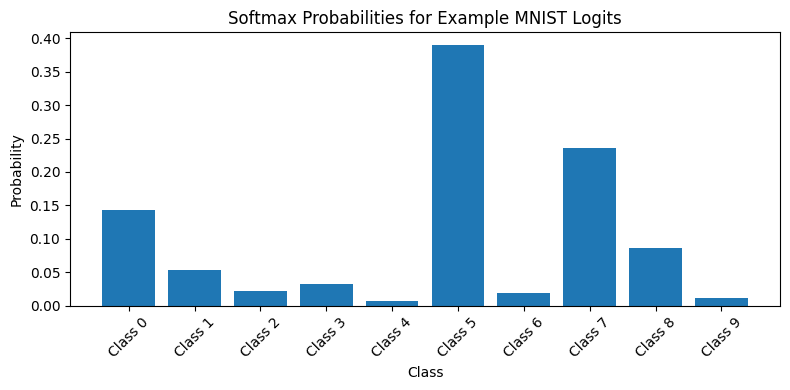

In [38]:

# Pure NumPy implementation of Softmax with numerical stability
def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    Uses the "subtract max" trick for numerical stability.
    """
    shift_x = x - np.max(x)
    exp_x = np.exp(shift_x)
    return exp_x / np.sum(exp_x)

# Example: 10-class logits (e.g., raw outputs for MNIST digits 0–9)
logits = np.array([2.0, 1.0, 0.1, 0.5, -1.0, 3.0, 0.0, 2.5, 1.5, -0.5])
probs = softmax(logits)

# Create DataFrame and print it
df = pd.DataFrame({
    'Logit': logits,
    'Softmax Probability': probs
}, index=[f"Class {i}" for i in range(len(logits))])

print("Logits vs. Softmax Probabilities:\n")
print(df.to_string())

# Bar plot of the probabilities
plt.figure(figsize=(8, 4))
plt.bar(df.index, df['Softmax Probability'])
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Softmax Probabilities for Example MNIST Logits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Swish Activation Function 
$swish(x)=xsigmoid(\beta x)$
#### Also used in some financial risk applications
with an option value type of function, used in financial derivative pricing 
Option pricing , counterparty risk valuation adjustment with  DNN 
{https://arxiv.org/pdf/1809.02233}

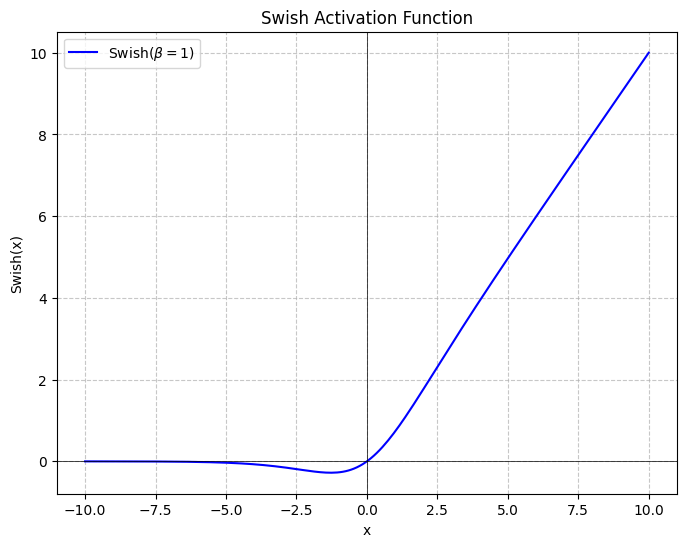

In [39]:


# Define the Swish activation function
def swish(x, beta=1.0):
    return x * (1 / (1 + np.exp(-beta * x)))

# Generate input data
x = np.linspace(-10, 10, 200)

# Calculate Swish output
y_swish = swish(x)

# Plotting the Swish function
plt.figure(figsize=(8, 6))
plt.plot(x, y_swish, label=r'Swish($\beta=1$)', color='blue')
plt.title('Swish Activation Function')
plt.xlabel('x')
plt.ylabel('Swish(x)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.savefig('swish_activation_function.png')

## 3.1 Loss Function
A loss function (or cost function) measures how well the  model’s predictions match the true targets. During the training, we minimize this loss to improve accuracy.
Can be customlized

| Task Type             | Loss Function               |
| --------------------- | --------------------------- |
| Regression            | MSE, MAE, Huber             |
| Binary Classification | Binary Cross-Entropy, Hinge |
| Multi-class   Classification         | Categorical CE, Focal (imbalanced)       |
| Imbalanced Classes    | Focal, Weighted CE          |
| Segmentation          | Dice, IoU                   |
| Sequence Alignment    | CTC                         |
| Metric Learning       | Triplet, Contrastive        |
| GAN Training          | WGAN, LS-GAN                |

### 1. Regression Losses (examples)
#### 1.1 Mean Squared Error (MSE), MAE etc..
$$
        L_{\rm MSE} = \frac{1}{N}\sum_{i=1}^N (y_i - \hat y_i)^2

$$
### 2. Classification Losses (example: cross-entropy loss )

##### Cross entropy Loss
Cross Entropy Loss is choosen to ensure the predicited lable $\hat{Y}$ is close to actul label Y
Cross entropy is used to measure the distance between two probability distributions. In machine learning contexts, we use the discrete cross-entropy loss (CE) between class label y and the predicted probability p when we train logistic regression or neural network classifiers on a dataset consisting of n training examples

$$
L_{CE} = -\frac{1}{N} \sum_{i=1}^{N} \log\bigl(p_{i,\,y_i} + \varepsilon\bigr)
$$

where  
- N is the batch size.  
- $p_{i,y_i}$ the model’s predicted probability for the true class $(y_i)$ of sample i.  
- $\varepsilon$ (e.g., $(10^{-15})$) is a small constant for numerical stability. 
- can be binary or catgorical cross-entopy



In [40]:
## implementation
## MSE
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def cross_entropy_loss(x_pred, y):
        """
        Compute Cross-Entropy Loss based on prediction and labels
        :param x_pred: Probabilities from the model (N, num_classes)
        :param y: Labels of instances in the batch
        :return: The computed Cross-Entropy Loss
        """
        # Vectorized implementation
        selected_probs = x_pred[np.arange(len(y)), y]
        # Add small epsilon for numerical stability
        log_likelihood = -np.log(selected_probs + 1e-15)
        loss = np.mean(log_likelihood)
        return loss

## 4. Softmax Regression Model
### We need to have a model for predicting mutiple class labels such as classfiy 0-9. Extend from a binary case (sigmoid/Logistic regression)
### Now let's implement the Softmax Regression model (Start with a Single layer neural network)
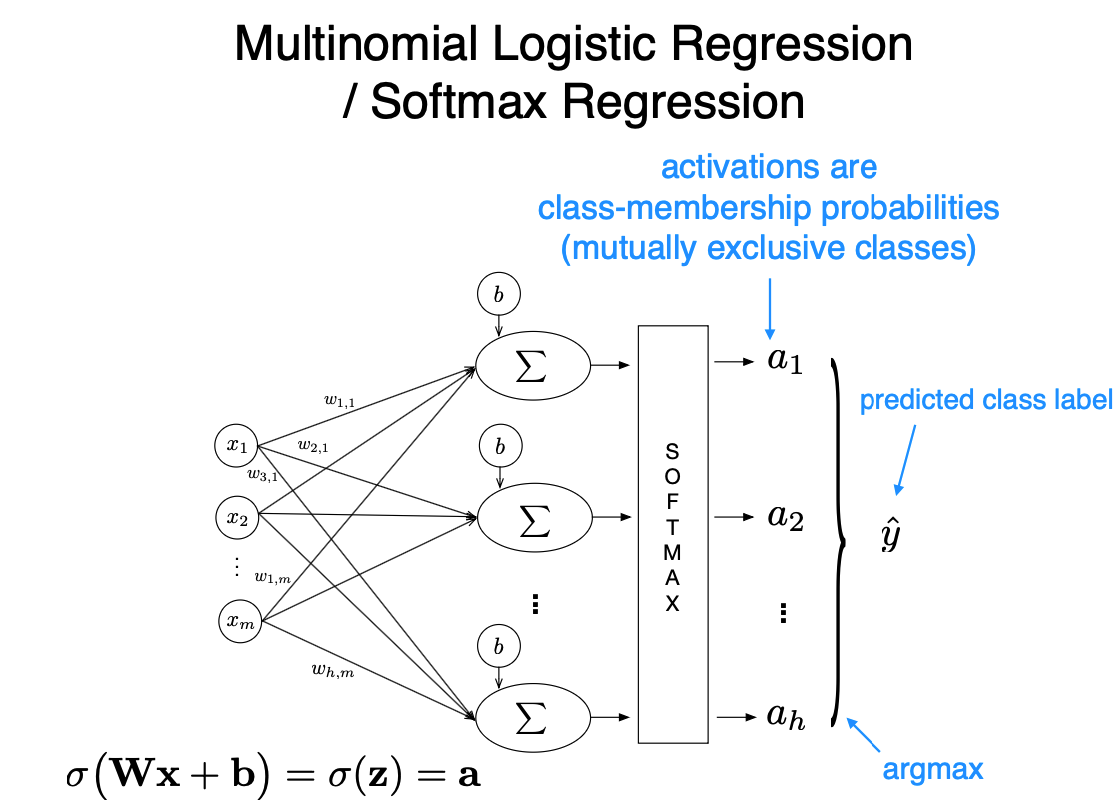

## One layer neural network:Softmax Regression step by step
###  A single layer softmax regression: Linear layer => ReLU => Softmax
###  initialized with normal random number
$$
W_1 \sim N(0,1)*0.001= N(0,0.001) 
$$
and
$$
W_1 \in \mathbb{R}^{784 \times 10}
$$
pass it to first layer

And 
$$
    Z=X W_1+ b
$$
which is   $   Z \in \mathbb{R}^{60 \times 10} $. Applying the ReLU to Z. 
$$ 
    A=ReLU(Z) 
$$. 
$A \in \mathbb{R}^{60 \times 10} $
and applying SOFTMAX to Z, dimension stay the same
 $$
P=\mathrm{softmax}(\mathbf{A})$$

$$
L_{CE} = -\frac{1}{N} \sum_{i=1}^{N} \log(P_{i,\,y_i} )
$$





## Backward propgation 
##### Before that some data transformation need to apply:
convert the actual lable Y as an one-hot vector  
$$
Y \in \mathbb{R}^{60 \times 10}
$$ 
each row have 10 elements, with 1 as the true label in the target location: first row is 5, Y[0,5]=1

### Compute the gradient in an computation graph
1. **Gradient w.r.t. activations \(A\)**  
some trick is needed in this derivation (https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/)
$$
   
   \frac{\partial L}{\partial A}
   = \frac{1}{N}\,\bigl(P - Y\bigr).
   
$$
2. **Gradient w.r.t. pre-activations \(Z\)**  
   $$
   
   \frac{\partial L}{\partial Z}
   = \frac{\partial L}{\partial A}\;\odot\;\mathrm{ReLU}'(Z),
   \quad
   \mathrm{ReLU}'(Z_{ij}) =
   \begin{cases}
     1, & Z_{ij}>0,\\
     0, & \text{otherwise.}
   \end{cases}
   $$
3. **Gradient w.r.t. weights \(W_1\)**  
   $$[
   \frac{\partial L}{\partial W_1}
   = X^\top \,\frac{\partial L}{\partial Z}.
   ]$$

#### **Remarks on computation graph** 
The whole process of forward backward pass is also known as computation graph, backward propgation, and   Automatic Differentiation https://www.youtube.com/watch?v=oY6-i2Ybin4

##### Used in many areas, more than deep learning
One popular application is **greek senstivity calcualtion** in financial derivative pricing 
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4588939

In [41]:
class SoftmaxRegression(_baseNetwork):
    def __init__(self, input_size=28 * 28, num_classes=10):
        """
        A single layer softmax regression: Linear layer => ReLU => Softmax
        """
        super().__init__(input_size, num_classes)
        self._weight_init()

    def _weight_init(self):
        """Initialize weights with small random values"""
        np.random.seed(1024)
        self.weights['W1'] = 0.001 * np.random.randn(self.input_size, self.num_classes)
        self.gradients['W1'] = np.zeros((self.input_size, self.num_classes))

    def forward(self, X, y, mode='train'):
        """
        Forward pass with optional gradient computation
        :param X: Input batch (N, 784)
        :param y: Labels (N,)
        :param mode: 'train' or 'valid'
        :return: loss, accuracy
        """
        # Forward pass
        Z = np.dot(X, self.weights['W1'])  # Linear transformation
        A = self.ReLU(Z)                   # ReLU activation
        probabilities = self.softmax(A)    # Softmax for probabilities
        
        # Compute loss and accuracy
        loss = self.cross_entropy_loss(probabilities, y)
        accuracy = self.compute_accuracy(probabilities, y)

        # Compute gradients if in training mode
        if mode == 'train':
            # Create one-hot encoding
            y_onehot = np.eye(self.num_classes)[y]
            
            # Backpropagation
            # dL/dA = (probabilities - y_onehot) / batch_size
            dL_dA = (probabilities - y_onehot) / X.shape[0]
            
            # dL/dZ = dL/dA * dA/dZ (ReLU derivative)
            dA_dZ = self.ReLU_dev(Z)
            dL_dZ = dL_dA * dA_dZ
            
            # dL/dW = X^T * dL/dZ
            self.gradients['W1'] = np.dot(X.T, dL_dZ)

        return loss, accuracy

## Steps for end to end trianing one layer network
1. **Initialization**  
   - Randomly initialize weights `W` and biases `b`.  
   - Set `best_validation_accuracy = 0`.

2. **Training Loop (for each epoch)**  
   1. **Shuffle & Batch** the training set.  
   2. **Forward Pass**: compute activations and softmax outputs.  
   3. **Compute Loss & Accuracy** on each batch.  
   4. **Backpropagation**: compute gradients of loss w.r.t. `W` and `b`.  
   5. **Regularize & Update**:  
      - Add `λ·W` to gradients.  
      - Update:  
        ```  
        W ← W − α · ∇W  
        b ← b − α · ∇b  
        ```

3. **Validation (end of each epoch)**  
   - Run a forward pass on the validation set.  
   - Compute validation loss & accuracy.  
   - If accuracy improves, save current `W, b`.

4. **Final Testing**  
   - Load the best‐saved parameters.  
   - Evaluate loss & accuracy on the test set.

5. **Visualization & Return**  
   - Plot training vs. validation loss and accuracy curves.  
   - Return the best model parameters.  


Detailed code in section 9

## More detailed training steps


$$
\begin{array}{l} % 'l' specifies left alignment for this single column
\textbf{Algorithm: Neural Network End-to-End Training} \\
\textbf{Input:} \text{ Training Data } (X_{\text{train}}, y_{\text{train}}), \text{ Validation Data } (X_{\text{val}}, y_{\text{val}}), \text{ Test Data } (X_{\text{test}}, y_{\text{test}}) \\
\textbf{Hyperparameters:} \text{ Learning Rate } \alpha, \text{ Regularization Strength } \lambda, \text{ Batch Size, Number of Epochs} \\
\textbf{Output:} \text{ Trained Neural Network Model (Best Parameters)} \\
\\
\textbf{1. Initialization} \\
\quad \text{Initialize all weights } W \text{ with small random values.} \\
\quad \text{Initialize all biases } b \text{ to zeros.} \\
\quad \text{Initialize best\_validation\_accuracy = 0.} \\
\quad \text{Initialize Best\_Model\_Parameters = null.} \\
\\
\textbf{2. Training Loop (Epochs)} \\
\quad \textbf{For } \text{epoch from 1 to Number\_of\_Epochs:} \\
\quad \quad \text{Print "Starting Epoch \{epoch\}"} \\
\quad \quad \text{Shuffle Training Data } (X_{\text{train}}, y_{\text{train}}) \\
\quad \quad \text{Initialize epoch\_train\_loss = 0, epoch\_train\_accuracy = 0, total\_samples = 0} \\
\\
\textbf{3. Batch Processing within Epoch} \\
\quad \textbf{For each } \text{batch } (X_{\text{batch}}, y_{\text{batch}}) \text{ in shuffled Training Data:} \\
\quad \quad \textbf{3.1. Forward Pass} \\
\quad \quad \quad \text{Compute } Z_1 = X_{\text{batch}} \cdot W_1 + b_1 \\
\quad \quad \quad \text{Compute } A_1 = \text{Sigmoid}(Z_1) = \frac{1}{1 + e^{-Z_1}} \\
\quad \quad \quad \text{Compute } Z_2 = A_1 \cdot W_2 + b_2 \\
\quad \quad \quad \text{Compute Probabilities } P = \text{Softmax}(Z_2) = \frac{e^{Z_2}}{\sum_{j} e^{Z_2^{(j)}}} \\
\\
\quad \quad \textbf{3.2. Compute Loss and Accuracy} \\
\quad \quad \quad \text{Convert } y_{\text{batch}} \text{ to one-hot encoding } y_{\text{onehot}}. \\
\quad \quad \quad \text{Compute Loss } L = -\frac{1}{N} \sum_{i=1}^{N} \log(P^{(i, y_{\text{batch}}^{(i)})}) \\
\quad \quad \quad \text{Compute Accuracy } \text{Acc} = \text{mean}(\text{argmax}(P, \text{axis}=1) == y_{\text{batch}}) \\
\\
\quad \quad \textbf{3.3. Backpropagation (Compute Gradients)} \\
\quad \quad \quad \text{Compute } \frac{\partial L}{\partial Z_2} = (P - y_{\text{onehot}}) / N \\
\quad \quad \quad \text{Compute } dW_2 = A_1^T \cdot \frac{\partial L}{\partial Z_2} \\
\quad \quad \quad \text{Compute } db_2 = \sum_{\text{rows}} \frac{\partial L}{\partial Z_2} \\
\quad \quad \quad \text{Compute } \frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} \cdot W_2^T \\
\quad \quad \quad \text{Compute } \frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \odot \text{Sigmoid\_dev}(Z_1) \\
\quad \quad \quad \text{Compute } dW_1 = X_{\text{batch}}^T \cdot \frac{\partial L}{\partial Z_1} \\
\quad \quad \quad \text{Compute } db_1 = \sum_{\text{rows}} \frac{\partial L}{\partial Z_1} \\
\\
\quad \quad \textbf{3.4. Apply Regularization} \\
\quad \quad \quad dW_1 = dW_1 + \lambda \cdot W_1 \\
\quad \quad \quad dW_2 = dW_2 + \lambda \cdot W_2 \\
\\
\quad \quad \textbf{3.5. Update Parameters (Optimization)} \\
\quad \quad \quad W_1 = W_1 - \alpha \cdot dW_1 \\
\quad \quad \quad b_1 = b_1 - \alpha \cdot db_1 \\
\quad \quad \quad W_2 = W_2 - \alpha \cdot dW_2 \\
\quad \quad \quad b_2 = b_2 - \alpha \cdot db_2 \\
\\
\quad \quad \text{Add } L \text{ to epoch\_train\_loss, Add Acc to epoch\_train\_accuracy, Add batch\_size to total\_samples.} \\
\quad \textbf{End For} \\
\\
\quad \text{Calculate average training\_loss and training\_accuracy for the epoch.} \\
\quad \text{Print "Epoch \{epoch\} Training: Loss=\{training\_loss:.4f\}, Accuracy=\{training\_accuracy:.4f\}"} \\
\\
\textbf{4. Validation} \\
\quad \text{Perform Forward\_Pass\_Only on Validation Data } (X_{\text{val}}, y_{\text{val}}). \\
\quad \text{Calculate validation\_loss and validation\_accuracy.} \\
\quad \text{Print "Epoch \{epoch\} Validation: Loss=\{validation\_loss:.4f\}, Accuracy=\{validation\_accuracy:.4f\}"} \\
\\
\textbf{5. Model Saving} \\
\quad \textbf{If } \text{validation\_accuracy } > \text{ best\_validation\_accuracy:} \\
\quad \quad \text{best\_validation\_accuracy = validation\_accuracy} \\
\quad \quad \text{Best\_Model\_Parameters = copy of current } W_1, b_1, W_2, b_2. \\
\quad \textbf{End If} \\
\\
\textbf{6. Final Evaluation} \\
\quad \text{Load Best\_Model\_Parameters.} \\
\quad \text{Perform Forward\_Pass\_Only on Test Data } (X_{\text{test}}, y_{\text{test}}). \\
\quad \text{Calculate test\_loss and test\_accuracy.} \\
\quad \text{Print "Final Test Accuracy: \{test\_accuracy:.4f\}"} \\
\\
\textbf{7. Visualization} \\
\quad \text{Plot training/validation loss and accuracy curves over epochs.} \\
\textbf{Return } \text{Best\_Model\_Parameters}
\end{array}
$$


## Two layer neural network

### First layer with 128 nodes, initialized with normal random number
$$
W_1 \sim N(0,1)*0.001= N(0,0.001) 
$$
and
$$
W_1 \in \mathbb{R}^{784 \times 128}
$$
### Gradient size
$$
W' \in \mathbb{R}^{784 \times 10} 
$$
graident with respect to 10 classes 

### second layer with 128 nodes and 10 classes, initialized with normal random number
$$
W_2 \sim N(0,1)*0.001= N(0,0.001) 
$$
and
$$
W_2 \in \mathbb{R}^{128 \times 10}
$$



## two layer training step 

In [42]:
class TwoLayerNet(_baseNetwork):
    def __init__(self, input_size=28 * 28, num_classes=10, hidden_size=128):
        super().__init__(input_size, num_classes)
        self.hidden_size = hidden_size
        self._weight_init()

    def _weight_init(self):
        """Initialize weights and biases"""
        np.random.seed(1024)
        
        # Layer 1: input_size -> hidden_size
        self.weights['W1'] = 0.001 * np.random.randn(self.input_size, self.hidden_size)
        self.weights['b1'] = np.zeros(self.hidden_size)
        
        # Layer 2: hidden_size -> num_classes
        self.weights['W2'] = 0.001 * np.random.randn(self.hidden_size, self.num_classes)
        self.weights['b2'] = np.zeros(self.num_classes)

        # Initialize gradients
        self.gradients['W1'] = np.zeros((self.input_size, self.hidden_size))
        self.gradients['b1'] = np.zeros(self.hidden_size)
        self.gradients['W2'] = np.zeros((self.hidden_size, self.num_classes))
        self.gradients['b2'] = np.zeros(self.num_classes)

    def forward(self, X, y, mode='train'):
        """
        Forward pass through two layers with sigmoid activation
        Architecture: Linear -> Sigmoid -> Linear -> Softmax
        """
        batch_size = X.shape[0]
        
        # Layer 1: Linear transformation + Sigmoid activation
        Z1 = np.dot(X, self.weights['W1']) + self.weights['b1']
        A1 = self.sigmoid(Z1)
        
        # Layer 2: Linear transformation + Softmax
        Z2 = np.dot(A1, self.weights['W2']) + self.weights['b2']
        probabilities = self.softmax(Z2)
        
        # Compute loss and accuracy
        loss = self.cross_entropy_loss(probabilities, y)
        accuracy = self.compute_accuracy(probabilities, y)

        # Backpropagation (if training)
        if mode == 'train':
            # Create one-hot encoding
            y_onehot = np.eye(self.num_classes)[y]
            
            # Gradients for output layer
            dL_dZ2 = (probabilities - y_onehot) / batch_size
            
            # Gradients for W2 and b2
            self.gradients['W2'] = np.dot(A1.T, dL_dZ2)
            self.gradients['b2'] = np.sum(dL_dZ2, axis=0)
            
            # Gradients for hidden layer
            dL_dA1 = np.dot(dL_dZ2, self.weights['W2'].T)
            dA1_dZ1 = self.sigmoid_dev(Z1)
            dL_dZ1 = dL_dA1 * dA1_dZ1
            
            # Gradients for W1 and b1
            self.gradients['W1'] = np.dot(X.T, dL_dZ1)
            self.gradients['b1'] = np.sum(dL_dZ1, axis=0)

        return loss, accuracy

## Optimization Implementation

### SGD and regulization
First defined the objective function/cost function $ J $ for optimize 

$$
J=L_{CE}+R(W)
$$

AKA: Overall loss
#### L2 Regularization 

If the weights are allowed to take values as high as possible, the model can overfit to the training data. To prevent this from happening a Regularization term $𝑅(𝑊)$
is added to the loss function. The regularization term is the squared some of the weight matrix $𝑊$
. Mathematically, a L2 Norm is 
$$
R(W)=\sum_k \sum_l W_{k,l}^2= \|W\|_F^2,  \\
\frac{\partial R}{\partial W}=2W
$$
L2 Regularization is
$$
\frac{\lambda}{2}\|W\|_F^2
$$
$$

J_{B}(\theta)
\;=\;
\underbrace{\frac{1}{\lvert B\rvert}\sum_{i\in B}\ell_{i}(\theta)}_{\text{average data loss over batch}}
\;+\;
\underbrace{\frac{\lambda}{2}\,\lVert W\rVert_{F}^{2}}_{\text{L}_{2}\text{ regularization on the weights}},

$$

$$

\frac{\partial}{\partial W_{k,l}}\!\Bigl(\tfrac{\lambda}{2}\,W_{k,l}^2\Bigr)
= \tfrac{\lambda}{2}\cdot 2\,W_{k,l}
= \lambda\,W_{k,l}
\

$$
And in gradient form is just adding the $\lambda W$ to the gradient w.r.t loss, $\lambda$ is another hyperparameter regulization term


#### Grdient descent
$$
W^{(t+1)} = W^{(t)} - \eta\,\nabla_{W} J(W)\,, \\[1ex] \nabla_{W} J(W)
$$
can be found from the equations mentioned above, $\eta$ is the learning rate, another hyper parameter

The key point is that the gradient  points in the direction of steepest increase of the loss 
$J(W)$. Since we want to minimize $J$, we must step against the gradient, so it is minus the weights everytime. 

##### Stochastic components

Happens in `generate_batched_data`, where the batch is randomly shuffled:

```python
random.shuffle(zip_list)  # ← randomizes the order of all samples


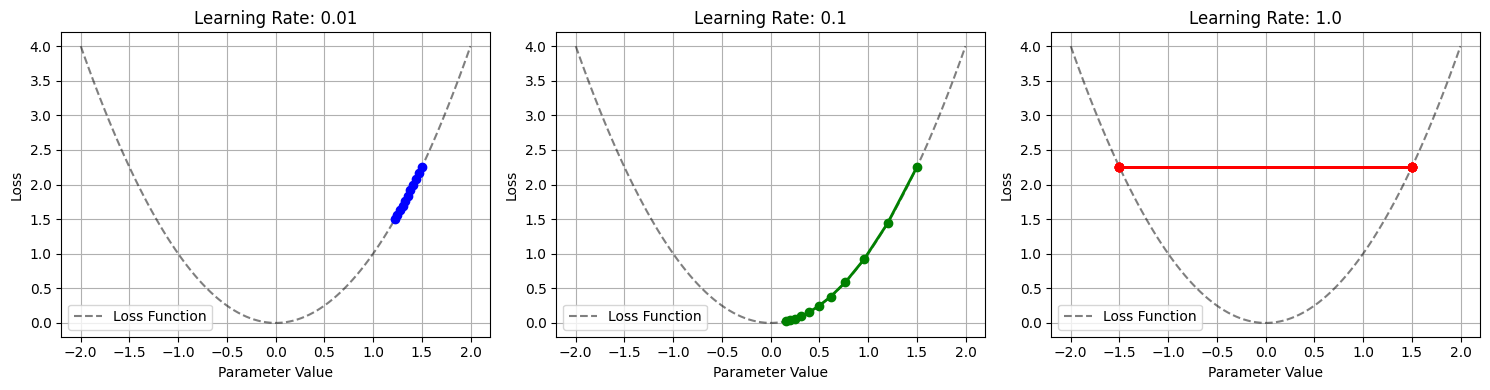

SGD Optimizer implemented successfully!


In [43]:
class _BaseOptimizer:
    def __init__(self, learning_rate=1e-4, reg=1e-3):
        self.learning_rate = learning_rate
        self.reg = reg

    def update(self, model):
        pass

    def apply_regularization(self, model):
        """Apply L2 penalty to model weights (not biases)"""
        for param_name in model.weights.keys():
            if 'W' in param_name:  # Only regularize weight matrices, not biases
                model.gradients[param_name] += self.reg * model.weights[param_name]

class SGD(_BaseOptimizer):
    def __init__(self, learning_rate=1e-4, reg=1e-3):
        super().__init__(learning_rate, reg)

    def update(self, model):
        """Update model weights using gradient descent"""
        # Apply L2 regularization
        self.apply_regularization(model)
        
        # Update all parameters
        for param_name in model.weights.keys():
            model.weights[param_name] -= self.learning_rate * model.gradients[param_name]

# Let's visualize the effect of different learning rates
def plot_learning_rate_effects():
    x = np.linspace(-2, 2, 100)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Different learning rates
    learning_rates = [0.01, 0.1, 1.0]
    colors = ['blue', 'green', 'red']
    
    for i, (lr, color) in enumerate(zip(learning_rates, colors)):
        # Simulate gradient descent on a simple quadratic function
        positions = [1.5]  # Starting position
        for _ in range(10):
            gradient = 2 * positions[-1]  # Gradient of x^2
            new_pos = positions[-1] - lr * gradient
            positions.append(new_pos)
        
        axes[i].plot(x, x**2, 'k--', alpha=0.5, label='Loss Function')
        axes[i].plot(positions, [p**2 for p in positions], 'o-', color=color, linewidth=2, markersize=6)
        axes[i].set_title(f'Learning Rate: {lr}')
        axes[i].set_xlabel('Parameter Value')
        axes[i].set_ylabel('Loss')
        axes[i].grid(True)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_rate_effects()
print("SGD Optimizer implemented successfully!")

##### Adam Optimizer used in MODEL PI

**Implementation (extends `_BaseOptimizer`):**

```python
class Adam(_BaseOptimizer):
    def __init__(self, learning_rate=1e-3, reg=1e-3,
                 beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(learning_rate, reg)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}     # 1st moment
        self.v = {}     # 2nd moment
        self.t = 0      # time step

    def update(self, model):
        self.t += 1
        self.apply_regularization(model)
        for name, w in model.weights.items():
            g = model.gradients[name]
            # Initialize moments
            self.m.setdefault(name, np.zeros_like(g))
            self.v.setdefault(name, np.zeros_like(g))
            # Update biased first & second moment estimates
            self.m[name] = self.beta1 * self.m[name] + (1 - self.beta1) * g
            self.v[name] = self.beta2 * self.v[name] + (1 - self.beta2) * (g * g)
            # Bias‐corrected moments
            m_hat = self.m[name] / (1 - self.beta1**self.t)
            v_hat = self.v[name] / (1 - self.beta2**self.t)
            # Parameter update
            model.weights[name] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)


**Adam Update Equations**

\[
\begin{aligned}
m_t &= \beta_1\,m_{t-1} + (1-\beta_1)\,g_t,\\
v_t &= \beta_2\,v_{t-1} + (1-\beta_2)\,g_t^2,\\
\hat m_t &= \frac{m_t}{1-\beta_1^t},\\
\hat v_t &= \frac{v_t}{1-\beta_2^t},\\
\theta_t &= \theta_{t-1} - \eta \,\frac{\hat m_t}{\sqrt{\hat v_t} + \varepsilon}.
\end{aligned}
\]

### If using PyTorch
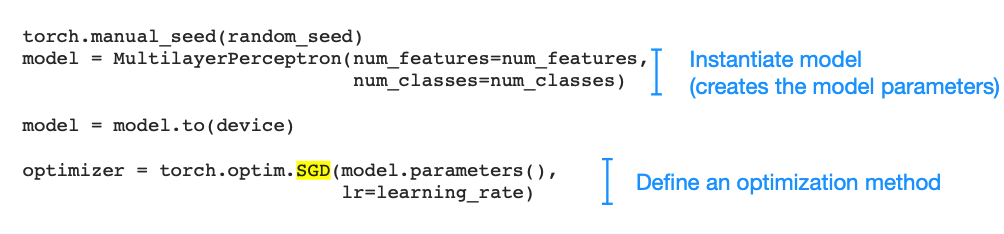

## 8. Training Pipeline

Now let's implement the complete training and evaluation pipeline:

Note that it is not pass the whole training data,
##### but a batch data $X$ each bacth is only 60 datapoints  
Total training data size: 48000, with 60 batchs, number of batch per epoch is 800
$$
X \in \mathbb{R}^{60 \times 784}
$$

In [44]:
def train_epoch(epoch, batched_train_data, batched_train_label, model, optimizer, debug=True):
    """Train the model for one epoch"""
    epoch_loss = 0.0
    epoch_acc = 0.0
    total_samples = 0
    
    for batch_idx, (batch_data, batch_labels) in enumerate(zip(batched_train_data, batched_train_label)):
        start_time = time.time()
        
        # Forward pass
        loss, accuracy = model.forward(batch_data, batch_labels, mode='train')
        
        # Backward pass (update weights)
        optimizer.update(model)
        
        # Accumulate metrics
        batch_size = batch_data.shape[0]
        epoch_loss += loss * batch_size
        epoch_acc += accuracy * batch_size
        total_samples += batch_size
        
        # Print progress
        if batch_idx % 5 == 0 and debug:
            batch_time = time.time() - start_time
            print(f'Epoch [{epoch}][{batch_idx}/{len(batched_train_data)}] '
                  f'Time: {batch_time:.3f}s Loss: {loss:.4f} Acc: {accuracy:.4f}')
    
    # Average over all samples
    epoch_loss /= total_samples
    epoch_acc /= total_samples
    
    if debug:
        print(f"* Epoch {epoch} Training - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    return epoch_loss, epoch_acc

def evaluate(batched_test_data, batched_test_label, model, debug=True):
    """Evaluate the model on test data"""
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0
    
    for batch_idx, (batch_data, batch_labels) in enumerate(zip(batched_test_data, batched_test_label)):
        # Forward pass only (no training)
        loss, accuracy = model.forward(batch_data, batch_labels, mode='valid')
        
        # Accumulate metrics
        batch_size = batch_data.shape[0]
        total_loss += loss * batch_size
        total_acc += accuracy * batch_size
        total_samples += batch_size
        
        if batch_idx % 5 == 0 and debug:
            print(f'Eval [{batch_idx}/{len(batched_test_data)}] Acc: {accuracy:.4f}')
    
    # Average over all samples
    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples
    
    return avg_loss, avg_acc

def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
    """Plot training and validation curves"""
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curves
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

print("Training pipeline implemented successfully!")

Training pipeline implemented successfully!


## 9. full training end to end

### One layer neural network hyper parameter
        'model_type': 'SoftmaxRegression',
        'epochs': 15,
        'batch_size': 60,
        'learning_rate': 0.1,
        'hidden layer': 128,
        'reg': 0.001

In [45]:
def run_experiment(model_type='TwoLayerNet', epochs=10, batch_size=32, learning_rate=0.01, reg=0.001):
    """Run a complete training experiment"""
    print(f"\n{'='*50}")
    print(f"Training {model_type}")
    print(f"{'='*50}")
    
    # Create model
    if model_type == 'SoftmaxRegression':
        model = SoftmaxRegression()
    elif model_type == 'TwoLayerNet':
        model = TwoLayerNet(hidden_size=128)
    else:
        raise ValueError("model_type must be 'SoftmaxRegression' or 'TwoLayerNet'")
    
    # Create optimizer
    optimizer = SGD(learning_rate=learning_rate, reg=reg)
    
    # Training history
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    # Best model tracking
    best_val_acc = 0.0
    best_model = None
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print("-" * 30)
        
        # Prepare training batches (with shuffling)
        batched_train_data, batched_train_labels = generate_batched_data(
            train_data, train_labels, batch_size=batch_size, shuffle=True, seed=epoch
        )
        
        # Train for one epoch
        train_loss, train_acc = train_epoch(
            epoch + 1, batched_train_data, batched_train_labels, model, optimizer, debug=True
        )
        
        # Validation
        batched_val_data, batched_val_labels = generate_batched_data(
            val_data, val_labels, batch_size=batch_size, shuffle=False
        )
        val_loss, val_acc = evaluate(batched_val_data, batched_val_labels, model, debug=False)
        
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        # Save history
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model)
    
    # Test on best model
    print(f"\n{'='*30}")
    print("Final Test Evaluation")
    print(f"{'='*30}")
    
    batched_test_data, batched_test_labels = generate_batched_data(
        test_data, test_labels, batch_size=batch_size, shuffle=False
    )
    test_loss, test_acc = evaluate(batched_test_data, batched_test_labels, best_model, debug=False)
    
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Test Accuracy: {test_acc:.4f}")
    
    return {
        'model_type': model_type,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'best_model': best_model
    }

def run_experiment(model_type='TwoLayerNet', epochs=10, batch_size=32, learning_rate=0.01, reg=0.001):
    """Run a complete training experiment"""
    print(f"\n{'='*50}")
    print(f"Training {model_type}")
    print(f"{'='*50}")
    
    # Create model
    if model_type == 'SoftmaxRegression':
        model = SoftmaxRegression()
    elif model_type == 'TwoLayerNet':
        model = TwoLayerNet(hidden_size=128)
    else:
        raise ValueError("model_type must be 'SoftmaxRegression' or 'TwoLayerNet'")
    
    # Create optimizer
    optimizer = SGD(learning_rate=learning_rate, reg=reg)
    
    # Training history
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    # Best model tracking
    best_val_acc = 0.0
    best_model = None
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print("-" * 30)
        
        # Prepare training batches (with shuffling)
        batched_train_data, batched_train_labels = generate_batched_data(
            train_data, train_labels, batch_size=batch_size, shuffle=True, seed=epoch
        )
        
        # Train for one epoch
        train_loss, train_acc = train_epoch(
            epoch + 1, batched_train_data, batched_train_labels, model, optimizer, debug=True
        )
        
        # Validation
        batched_val_data, batched_val_labels = generate_batched_data(
            val_data, val_labels, batch_size=batch_size, shuffle=False
        )
        val_loss, val_acc = evaluate(batched_val_data, batched_val_labels, model, debug=False)
        
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        # Save history
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model)
    
    # Test on best model
    print(f"\n{'='*30}")
    print("Final Test Evaluation")
    print(f"{'='*30}")
    
    batched_test_data, batched_test_labels = generate_batched_data(
        test_data, test_labels, batch_size=batch_size, shuffle=False
    )
    test_loss, test_acc = evaluate(batched_test_data, batched_test_labels, best_model, debug=False)
    
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Test Accuracy: {test_acc:.4f}")
    
    return {
        'model_type': model_type,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'best_model': best_model
    }

# Configuration for experiments
configs = {
    'softmax': {
        'model_type': 'SoftmaxRegression',
        'epochs': 15,
        'batch_size': 60,
        'learning_rate': 0.1,
        'reg': 0.001
    },
    'twolayer': {
        'model_type': 'TwoLayerNet', 
        'epochs': 15,
        'batch_size': 60,
        'learning_rate': 0.1,
        'reg': 0.001
    }
}

print("Starting experiments with real MNIST data...")
print("This may take a few minutes depending on your hardware.\n")

# Run experiments with both models
print("Running Softmax Regression experiment...")
results_softmax = run_experiment(**configs['softmax'])

print("\nRunning Two-Layer Neural Network experiment...")
results_twolayer = run_experiment(**configs['twolayer'])

Starting experiments with real MNIST data...
This may take a few minutes depending on your hardware.

Running Softmax Regression experiment...

Training SoftmaxRegression

Epoch 1/15
------------------------------
Epoch [1][0/800] Time: 0.001s Loss: 2.3027 Acc: 0.1333
Epoch [1][5/800] Time: 0.000s Loss: 2.0434 Acc: 0.4000
Epoch [1][10/800] Time: 0.000s Loss: 1.7950 Acc: 0.5667
Epoch [1][15/800] Time: 0.000s Loss: 1.6509 Acc: 0.5667
Epoch [1][20/800] Time: 0.000s Loss: 1.5467 Acc: 0.7000
Epoch [1][25/800] Time: 0.000s Loss: 1.6764 Acc: 0.5333
Epoch [1][30/800] Time: 0.000s Loss: 1.7027 Acc: 0.5000
Epoch [1][35/800] Time: 0.000s Loss: 1.5264 Acc: 0.5833
Epoch [1][40/800] Time: 0.000s Loss: 1.6161 Acc: 0.5167
Epoch [1][45/800] Time: 0.000s Loss: 1.6104 Acc: 0.4833
Epoch [1][50/800] Time: 0.000s Loss: 1.2819 Acc: 0.6667
Epoch [1][55/800] Time: 0.000s Loss: 1.3474 Acc: 0.6167
Epoch [1][60/800] Time: 0.000s Loss: 1.5275 Acc: 0.5333
Epoch [1][65/800] Time: 0.000s Loss: 1.2732 Acc: 0.6667
Epoc

###    With Pytorch
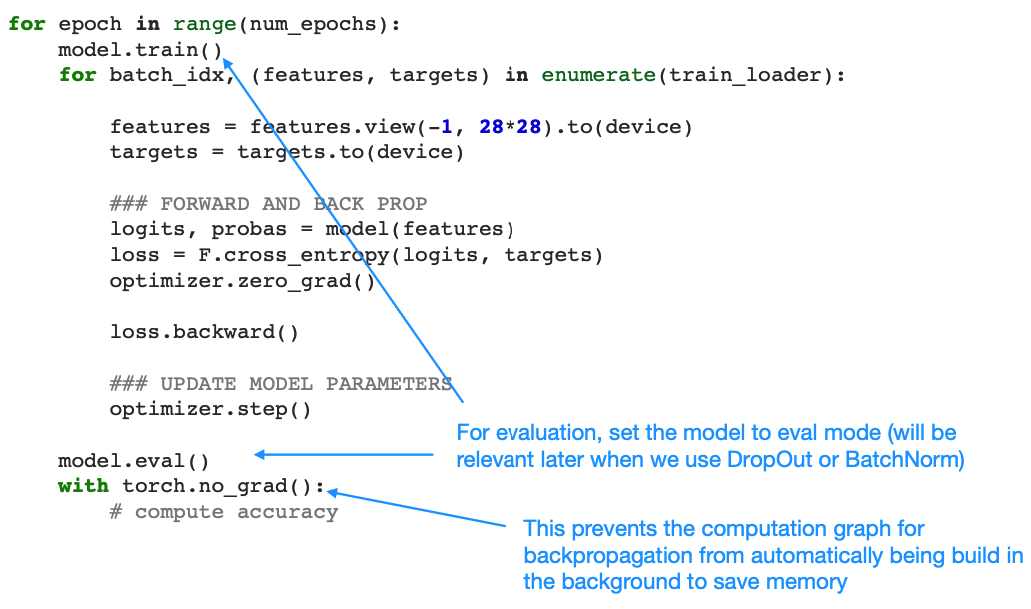

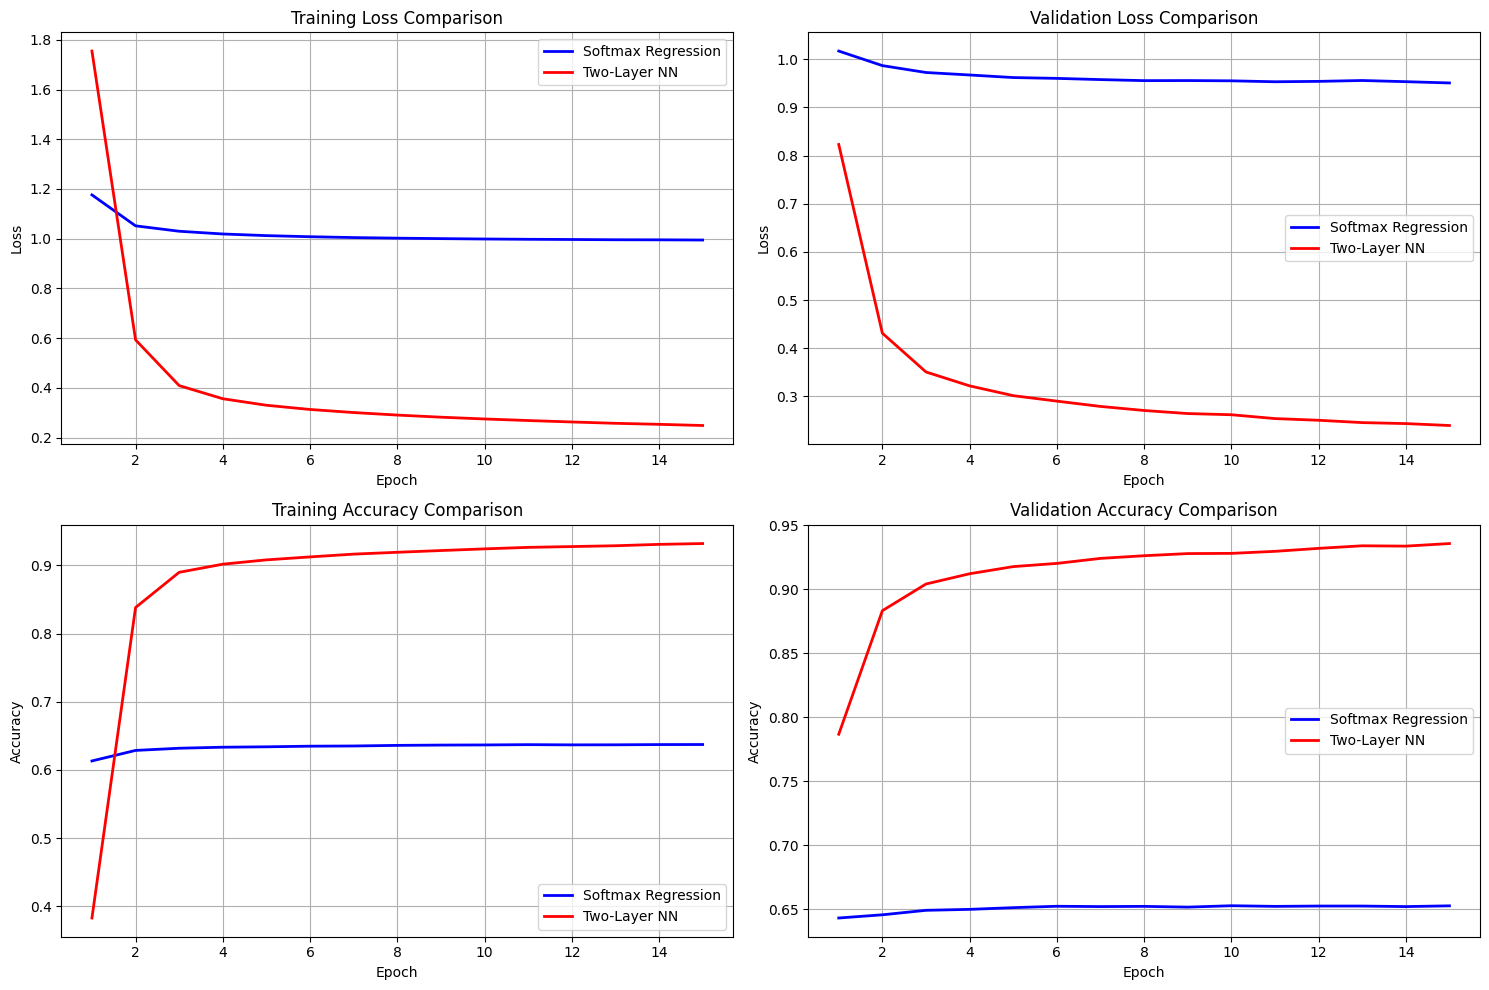


FINAL RESULTS SUMMARY
Model                Best Val Acc    Test Acc       
------------------------------------------------------------
Softmax Regression   0.6528          0.6345         
Two-Layer NN         0.9356          0.9348         

Two-Layer NN improvement over Softmax Regression: 0.3003 (30.03%)


In [46]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(results_softmax['train_losses']) + 1)

# Training Loss Comparison
axes[0,0].plot(epochs, results_softmax['train_losses'], 'b-', label='Softmax Regression', linewidth=2)
axes[0,0].plot(epochs, results_twolayer['train_losses'], 'r-', label='Two-Layer NN', linewidth=2)
axes[0,0].set_title('Training Loss Comparison')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# Validation Loss Comparison
axes[0,1].plot(epochs, results_softmax['val_losses'], 'b-', label='Softmax Regression', linewidth=2)
axes[0,1].plot(epochs, results_twolayer['val_losses'], 'r-', label='Two-Layer NN', linewidth=2)
axes[0,1].set_title('Validation Loss Comparison')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# Training Accuracy Comparison
axes[1,0].plot(epochs, results_softmax['train_accs'], 'b-', label='Softmax Regression', linewidth=2)
axes[1,0].plot(epochs, results_twolayer['train_accs'], 'r-', label='Two-Layer NN', linewidth=2)
axes[1,0].set_title('Training Accuracy Comparison')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend()
axes[1,0].grid(True)

# Validation Accuracy Comparison
axes[1,1].plot(epochs, results_softmax['val_accs'], 'b-', label='Softmax Regression', linewidth=2)
axes[1,1].plot(epochs, results_twolayer['val_accs'], 'r-', label='Two-Layer NN', linewidth=2)
axes[1,1].set_title('Validation Accuracy Comparison')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Summary Table
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"{'Model':<20} {'Best Val Acc':<15} {'Test Acc':<15}")
print("-" * 60)
print(f"{'Softmax Regression':<20} {results_softmax['best_val_acc']:<15.4f} {results_softmax['test_acc']:<15.4f}")
print(f"{'Two-Layer NN':<20} {results_twolayer['best_val_acc']:<15.4f} {results_twolayer['test_acc']:<15.4f}")
print("="*60)

# Performance improvement
improvement = results_twolayer['test_acc'] - results_softmax['test_acc']
print(f"\nTwo-Layer NN improvement over Softmax Regression: {improvement:.4f} ({improvement*100:.2f}%)")